In [20]:
import json
from itertools import product

import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

%matplotlib inline

In [116]:
def jl_to_df(fname):
    with open(fname) as f:
        return pd.DataFrame([json.loads(line) for line in f])
    
def get_data_matrix(tags, M=100, sparse_output=True):
    mlb = MultiLabelBinarizer(sparse_output=sparse_output)
    X = mlb.fit_transform(tags[:M])
    return mlb.classes_, X

def get_most_common(labels, X, N=100):
    # Sum columns
    counts = X.sum(axis=0)
    # Squeeze counts into 1 dimensional array
    counts = np.squeeze(np.asarray(counts))
    # Get indexes of most common popular labels
    idxs = np.argsort(-counts)[:N]
    return labels[idxs], X[:, idxs]

def get_distance_matrix(X):
    # Scipy pdist is much faster than sklearn pairwise_distances
    d = pdist(X, 'jaccard')
    # Return distances as a matrix
    return squareform(d)
    
def get_distance_matrix2(X):
    return pairwise_distances(
        X,
        metric=lambda x,y: 1 - jaccard_similarity_score(x,y)
    )

def format_nodes(labels, values):
    return [{"name": label, "value": value} for label, value in zip(labels, values)]

def format_links(d, minv, maxv):
    # It is important to filter the values, otherwise
    # most of them are 1 for labels that have no co-ocurrence
    # or close 1 by chance.
    # TODO: those values should be dynamically inferred.
    idx = product(range(d.shape[0]), range(d.shape[1]))
    return [{"source": i[0], "target": i[1] , "value": v}
            for i, v in zip(idx, d.flatten()) if v > minv and v < maxv]

def save_graph_data(d, labels, values, minv=0, maxv=1, out='data.json'):
    data = {
        "nodes": format_nodes(labels, values),
        "links": format_links(d, minv, maxv)
    }
    with open(out, "w") as f:
        f.write(json.dumps(data))

In [3]:
# Load data
df = jl_to_df("../data/theses_dump_21-03-2017.json")

In [130]:
# Get matrix representation
labels, X = get_data_matrix(df["topics"], M=120000)
labels, X = get_most_common(labels, X, N=1000)
X = X.toarray()
values = X.sum(axis=0)

In [131]:
# Compute distances
d = get_distance_matrix(X.T)

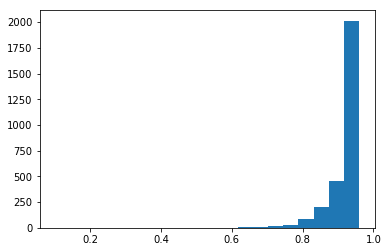

In [132]:
plt.hist(d.flatten(), bins=20, range=(0.1, 0.96))
plt.show()

In [133]:
d.shape

(1000, 1000)

In [134]:
labels.shape

(1000,)

In [135]:
values.shape

(1000,)

In [136]:
# Format data for graph
save_graph_data(d, labels, values, minv=0, maxv=0.96, out='force-layout/data.json')